<a href="https://colab.research.google.com/github/BluBloos/QMIND2021-2022/blob/main/src/HandTracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Right.

- So we seem to have everything split into seperate files now.
- What precisely is the next step?

- Integrate other changes in the google drive colab (not to be confused with the one that is in Github).
  - Namely, there are some changes to the MANO layer along with some work done for the loss functions.

- Add batch size as a parameter in the script.
  - Because we like to use it as a constant in various locations...


# SETUP

In [1]:
# Download updated project from Github.
!git pull

##### HANDLE DIFFS WHEN RUNNING IN COLAB #####
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
print("In Colab:", IN_COLAB)
import sys
if (IN_COLAB):
  sys.path.insert(1, '/content/src/')
##### HANDLE DIFFS WHEN RUNNING IN COLAB #####

########### TEST GPU AND RAM OF COLLAB INSTANCE ###########
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')
########### TEST GPU AND RAM OF COLLAB INSTANCE ###########

######### EXTERNAL LIBRARIES #########
import os
import pickle
import matplotlib.pyplot as plt
import imageio
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, UpSampling2D, MaxPool2D
from tensorflow.keras import Model
print("TensorFlow version:", tf.__version__)
#NOTE: Good resource. -> https://www.tensorflow.org/tutorials/quickstart/advanced
import cv2 # opencv, for image resizing.
######### EXTERNAL LIBRARIES #########

############## HELPER FUNCTIONS ############## 
# NOTE(Noah): Stole this function from Stackoverflow :)
def rgb2gray(rgb):
    return np.expand_dims(np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]), axis=2)
def resize(img, size):
    return cv2.resize(img, dsize=(size, size), interpolation=cv2.INTER_CUBIC)
############## HELPER FUNCTIONS ############## 

Already up to date.
In Colab: False
/bin/bash: nvidia-smi: command not found
Your runtime has 17.2 gigabytes of available RAM
Not using a high-RAM runtime
TensorFlow version: 2.8.0


# MODEL LOADING

In [ ]:
from mobilehand import MOBILE_HAND
from mobilehand_lfuncs import LOSS_3D

# The lower training loop assumes that the model is set as such.
model = MOBILE_HAND

# The lower training loop also assumes that we have the loss function set like so.
loss_fn = lambda pred, gt : LOSS_3D(pred,gt) 

# DATA LOADING

Begin single hand parse
00002.png
00005.png
00006.png
00007.png
00008.png
00013.png
00014.png
00018.png
00023.png
00026.png
00027.png
00032.png
00035.png
00036.png
00037.png
00039.png
00040.png
00041.png
00042.png
00043.png
00045.png
00046.png
00048.png
00050.png
00051.png
00053.png
00054.png
00056.png
00058.png
00059.png
00060.png
00061.png
00062.png
00063.png
00067.png
00068.png
00069.png
00070.png
00071.png
00074.png
00075.png
00078.png
00079.png
00084.png
00086.png
00091.png
00092.png
00094.png
00096.png
00097.png
00098.png
00101.png
00118.png
00121.png
00122.png
00123.png
00124.png
00126.png
00127.png
00133.png
00138.png
00139.png
00143.png
00144.png
00145.png
00146.png
00148.png
00149.png
00151.png
00152.png
00154.png
00156.png
00157.png
00160.png
00161.png
00162.png
00164.png
00167.png
00168.png
00172.png
00175.png
00178.png
00184.png
00185.png
00186.png
00188.png
00189.png
00190.png
00191.png
00197.png
Total elapsed time for single hand parse = 21.83582091331482 s
valid trainin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Elapsed for LoadData evaluation 1.0456161499023438 s


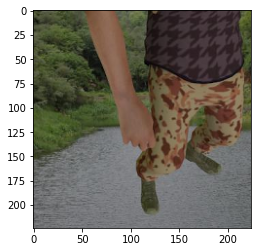

2022-02-20 18:11:23.883962: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Setup some params.
IMAGE_SIZE = 224
GRAYSCALE = False
TRAIN_AMOUNT = 192
TEST_AMOUNT = 96
IMAGE_CHANNELS = 1 if GRAYSCALE else 3

# Check if the dataset has been parsed yet. If not, parse.
data_dir = 'RHD_small' if IN_COLAB else '../RHD_small'
parsed_data_dir = 'SH_RHD' if IN_COLAB else '../SH_RHD'
import parsing_data
if not os.path.isdir(parsed_data_dir):
  os.mkdir(parsed_data_dir)
  os.mkdir(os.path.join(parsed_data_dir, 'evaluation'))
  os.mkdir(os.path.join(parsed_data_dir, 'evaluation', 'color'))
  os.mkdir(os.path.join(parsed_data_dir, 'training'))
  os.mkdir(os.path.join(parsed_data_dir, 'training', 'color'))
  parsing_data.parse_dataset(203, data_dir, parsed_data_dir)

data_dir = parsed_data_dir

# Load in the testing and training images.
x_train = np.zeros( (TRAIN_AMOUNT, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS) )
y_train = np.zeros( (TRAIN_AMOUNT, 21, 3) )
x_test = np.zeros( (TEST_AMOUNT, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS) ) 
y_test = np.zeros( (TEST_AMOUNT, 21, 3) )

def LoadData(dataAmount, dataType, np1):
  path = os.path.join(data_dir, dataType, 'color')
  
  count = 0
  for filename in os.listdir(path):
    filePath = os.path.join(path, filename)
    image = imageio.imread(filePath)
    _image = image.astype('float32')
    if GRAYSCALE:
      _image = rgb2gray(_image / 255)
    else:
      _image = _image / 255
    _image = resize(_image, IMAGE_SIZE)
    np1[count, :, :, :] = _image
    count += 1
    if (count >= dataAmount):
      break

print("Loading in the training data samples...")
start_time = time.time()
LoadData(TRAIN_AMOUNT, 'training', x_train)
x_train = x_train.astype('float32')
#y_train = y_train.astype('float32')
end_time = time.time()
print('Elapsed for LoadData training', end_time - start_time, 's')

print("Loading in the evaluation data samples...")
start_time = time.time()
LoadData(TEST_AMOUNT, 'evaluation', x_test)
x_test = x_test.astype('float32')
#y_test = y_test.astype('float32')
end_time = time.time()
print('Elapsed for LoadData evaluation', end_time - start_time, 's')

# Test print one of the images from the dataset.
_test = x_train[0] 
plt.imshow(_test)
plt.show()
#_test = y_train[0]
#plt.imshow(np.squeeze(_test))
#plt.show()

# Batch the data for tensorflow.
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# TODO(Noah): Is it feasible to now delete all the intermediate numpy arrays?
# TODO(Noah): Integrate code that max wrote to check if the dataset has been parsed.
# if the dataset has not been parsed yet, parse it, then load.

# TRAINING LOOP

In [ ]:
class StupidSimpleLossMetric():
    def __init__(self):
        self.losses = [] # empty python array 
    def __call__(self, loss):
        self.losses.append(loss)
    def result(self):
        return sum(self.losses) / len(self.losses)
    def reset_states(self):
        self.losses = []

optimizer = tf.keras.optimizers.Adam() # defaults should work just fine
train_loss = StupidSimpleLossMetric()
test_loss = StupidSimpleLossMetric()

# loss_fn = keras.losses.BinaryCrossentropy(from_logits=False) # from_logits=False just means that the values are between zero and one (a probability).
# loss_fn = lambda x, y: tf.math.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(x, y))

# train_accuracy = tf.keras.metrics.MeanAbsolutePercentageError(name='train_accuracy')
# test_accuracy = tf.keras.metrics.MeanAbsolutePercentageError(name='test_accuracy')

# @tf.function Compiles a function into a callable TensorFlow graph.
# https://www.tensorflow.org/guide/intro_to_graphs
'''def custom_loss_func(pred, labels):
    #return tf.math.reduce_sum( tf.math.square(labels - tf.cast(pred,tf.float64)))
    # now trying pixel-wise cross-entropy loss
    return -tf.math.reduce_sum(tf.math.log(pred) * labels)
'''

# Loss function unit test
input = tf.zeros([1, 39])  # mock pred of all zeros
label = np.expand_dims(y_train[0], axis=0)
loss = loss_fn(input, label)
print('Loss for pred of all zeros', loss.numpy())
#loss2 = loss_fn(label, label)
#print('Loss for perfect prediction', loss2.numpy())
input2 = tf.ones([1, 39])
loss3 = loss_fn(input2, label)
print('Loss for pred of all ones', loss3.numpy())

@tf.function
def train_step(input, gt):
    with tf.GradientTape() as tape:
        predictions = model(input)
        #loss = loss_func(predictions, segmentation_masks)
        #loss = np.dot(tf.reshape(segmentation_masks, [102400], tf.reshape(predictions, [102400])
        loss = loss_fn(predictions, gt)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss
    #train_accuracy(labels, predictions)
  
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  return loss_fn(predictions, labels)
  #test_accuracy(labels, predictions)

In [ ]:
# TODO: Reimplement loading in the saved model weights
# model.load_weights(checkpoint_path)

EPOCHS = 10 # sure...

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  print("Epoch", epoch)
  start = time.time()
  train_loss.reset_states()
  #train_accuracy.reset_states()
  test_loss.reset_states()
  #test_accuracy.reset_states()

  for images, labels in train_ds:
    loss = train_step(images, labels)
    train_loss(loss.numpy())

  for test_images, test_labels in test_ds:
    loss = test_step(test_images, test_labels)
    test_loss(loss.numpy())

  end = time.time()

  print(
    f'Epoch {epoch + 1}, '
    f'Time {end-start} s'
    f'Loss: {train_loss.result()}, '
    f'Test Loss: {test_loss.result()}, '
  )

  # for each epoch, we want to show the 
  #pred = model( _image )
  #plt.imshow(np.squeeze(pred))
  #plt.show()

# Save the model parameters
# TODO: Make it such that model parameters are saved after x many epochs as opposed to however
#   many epochs the model will be trained in total
#save_dir = '/content/drive/My Drive'
#checkpoint_path = save_dir + "/cp-{epoch:04d}.ckpt"
#model.save('current_model.h5py',save_path)
#model.save_weights(checkpoint_path.format(epoch=40))